In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import networkx as nx

from src.depth import DepthPoset, get_ordered_border_matrix_from_matrix_of_heights

from matplotlib import pyplot as plt

# Test geting border matrix method

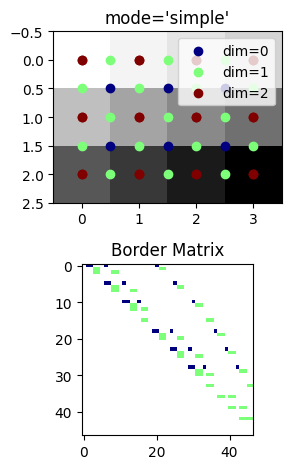

In [3]:
shape = (3, 4)
heights = np.linspace(0, 1, np.prod(shape)).reshape(shape)


modes = ['simple']

fig, axs = plt.subplots(2, len(modes), squeeze=False)

for i, mode in enumerate(modes):
    axs[0, i].set_title(f'mode={mode.__repr__()}')
    axs[0, i].imshow(heights, cmap='Greys')

    cmap = plt.get_cmap('jet')
    
    try:
        sources, matrix, dims, filtration = get_ordered_border_matrix_from_matrix_of_heights(heights, mode=mode)
        
        matrix = matrix.astype(float)
        matrix[matrix == 0] = np.nan
        matrix *= dims.reshape(-1, 1)

        for dim in np.unique(dims):
            y, x = np.array(list(sources[dims == dim])).mean(axis=1).transpose()
            axs[0, i].scatter(x, y, label=f'dim={dim}', color=cmap(dim/matrix.ndim))
        axs[0, i].legend()
        
        axs[1, i].set_title(f'Border Matrix')
        axs[1, i].imshow(matrix, vmin=0, vmax=heights.ndim, cmap=cmap)
    except Exception as err:
        axs[1, i].set_title(err)
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])

plt.tight_layout()
plt.show()

# 1-dimensional Random Walk

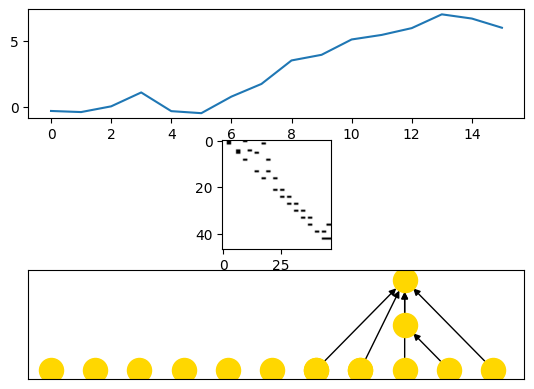

In [15]:
nsteps = 16

steps = np.random.normal(size=nsteps)
walk = np.cumsum(steps)

sources, matrix, dims, filter_values = get_ordered_border_matrix_from_matrix_of_heights(walk)
dp = DepthPoset.from_border_matrix(matrix.astype(int), dims=dims, filter_values=filter_values, sources=sources)



fig, axs = plt.subplots(3)

axs[0].plot(walk)
axs[1].imshow(matrix, cmap='Greys', vmin=0, vmax=1)

nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), node_color='gold', ax=axs[2], with_labels=False)
